In [131]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [132]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/umap_c20_n15_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/umap_c20_n15_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [133]:
participants = pd.read_csv(participants_file, index_col=0)


In [134]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [135]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [136]:
participants[:] = participants.sample(frac=1).values

In [137]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,1
mv_SYNESTHEX_S_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_M_Session1_S2_T1w,0,1,1
mv_SYNESTHEX_K_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_Y_Session1_S2_T1w,0,2,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,1,2,1
mv_SYNESTHEX_G_Session1_S2_T1w,0,2,1
mv_SYNESTHEX_D_Session1_S2_T1w,0,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

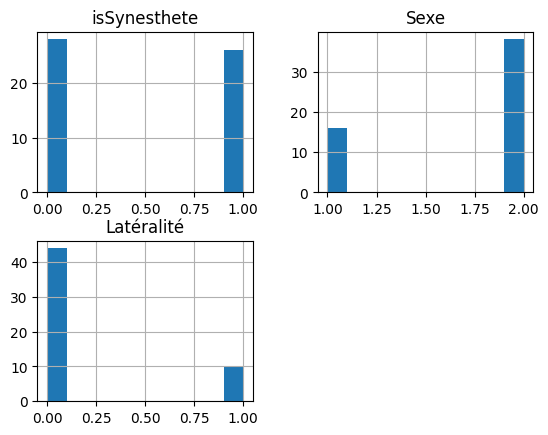

In [138]:
participants.hist()

In [139]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [140]:
model_paths = get_model_paths(path_champollion)

In [141]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [142]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [143]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    ukb_emb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]

    # Makes PCA on UkBioBank
    pca = PCA(n_components=5)
    pca.fit(ukb_emb)

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [144]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [145]:
result = []
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.4572537525159226
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
2.0226297466883545
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.4672033133695384
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
0.7895352071048884
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.7818147088403485
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-3

In [146]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           isSynesthete   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.491
Date:                Fri, 20 Sep 2024   Prob (F-statistic):              0.210
Time:                        11:56:19   Log-Likelihood:                -35.258
No. Observations:                  54   AIC:                             82.52
Df Residuals:                      48   BIC:                             94.45
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4444      0.073      6.111      0.000       0.298       0.591
0             -0.0122      0.062     -0.197      0.845      -0.136       0.112
1              0.0893      0.092      0.969      0.337      -0.096       0.275
2              0.0648      0.097      0.666      0.509      -0.131       0.261
3              0.2291      0.097      2.370      0.022       0.035       0.423
4              0.0939      0.123      0.766      0.447      -0.153       0.340
==============================================================================
Omnibus:                       55.569   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.224
Skew:                           0.033   Prob(JB):                       0.0734
Kurtosis:                       1.478   Cond. No.                         2.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [148]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.457254,0.221346,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,2.022630,0.092201,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.467203,0.798732,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.789535,0.562430,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.781815,0.567793,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.341496,0.263122,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,0.105453,0.990562,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,1.193560,0.326481,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,0.711357,0.617872,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [149]:
df['side'] = df['region'].str.split('_').str[-1]

In [150]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.457254,0.221346,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,2.022630,0.092201,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.467203,0.798732,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.789535,0.562430,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.781815,0.567793,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,1.341496,0.263122,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,0.105453,0.990562,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,1.193560,0.326481,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,0.711357,0.617872,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [151]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.05, color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [152]:
0.05/56

0.0008928571428571429

In [153]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
66,ORBITAL_left,2.327760,0.056851,20-56-02_0,ORBITAL_left/20-56-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
49,S.F.int.-F.C.M.ant._right,2.161355,0.074039,19-52-24_1,SFint-FCMant_right/19-52-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
67,ORBITAL_left,2.138775,0.076735,20-56-02_2,ORBITAL_left/20-56-02_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,2.022630,0.092201,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
9,S.Po.C._left,2.002677,0.095148,22-10-40_0,SPoC_left/22-10-40_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
23,CINGULATE_left,0.201223,0.960407,17-13-32_0,2024-07-15/17-13-32_0,/neurospin/dico/data/deep_folding/current/mode...,left
50,S.F.median-S.F.pol.tr.-S.F.sup._left,0.191192,0.964498,18-09-26_0,SFmedian-SFpoltr-SFsup_left/18-09-26_0,/neurospin/dico/data/deep_folding/current/mode...,left
28,CINGULATE_right,0.148967,0.979399,09-52-22_75,CINGULATE_right/09-52-22_75,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,0.105453,0.990562,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left


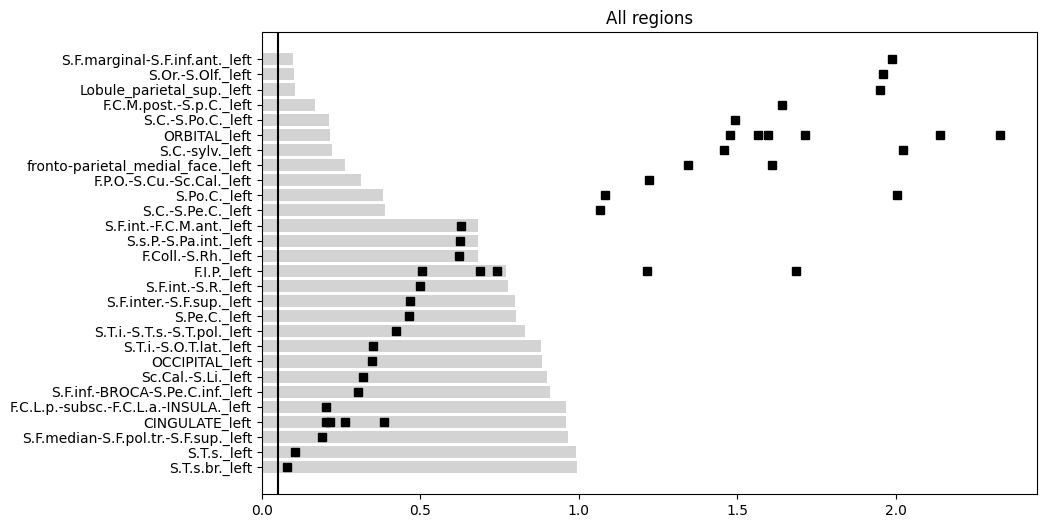

In [154]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

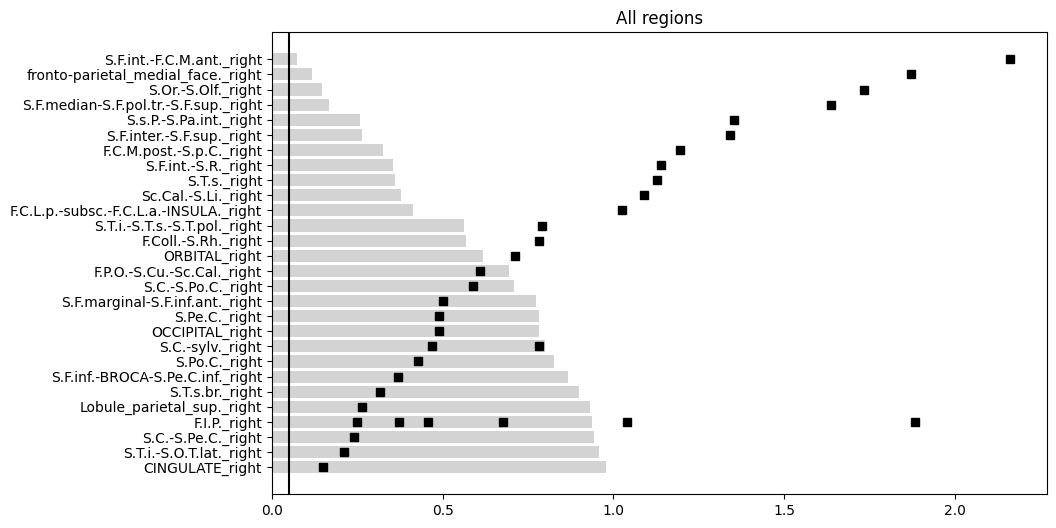

In [155]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [156]:
# df.to_csv(output_filename)